# Welcome!

This series of notebooks is focused on the creation, deployment, monitoring and management of a machine learning model for performing fraud detection. 

In this notebook we will be exploring the data, and training the machine learning model itself; in the form of an XGBoost classifier. 

This notebook and code within it is heavily inspired by the fantastic work of Arjun Joshua, you can find the original here: https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services/notebook

-----------------------------------
First, we install and import the relevant packages which we will use throughout the exploration and training process. 

In [ ]:
!conda create --name=seldon-workshop python=3.8 --yes

In [ ]:
!conda activate seldon-workshop

In [ ]:
!pip3 install -r requirements.txt

In [35]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi, DriftDetectorApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

# For repeatability
randomState = 5
np.random.seed(randomState)

We then download the dataset we will be using for the workshop, and load it into a Pandas DataFrame.

In [ ]:
!gsutil cp gs://tom-seldon-examples/workshops/financial-services/data/PS_20174392719_1491204439457_log.csv data/PS_20174392719_1491204439457_log.csv

In [4]:
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


It is worth taking a second to understand the features (columns of the table) within the dataset:
* `step`: This is a time series data set i.e. money transfers occur over time. 1 step represents 1 hour, with a total of 744 steps equivalent to 30 days. 
* `type`: The type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER.
* `amount`: Amount of the transaction in local currency.
* `nameOrig`: Customer name who started the transaction.
* `oldBalanceOrig`: Initial balance before the transaction.
* `newBalanceOrig`: New balance after the transaction.
* `nameDest`: Customer name who is the recipient of the transaction.
* `oldBalanceDest`: Initial balance of the recipient before the transaction.
* `newBalanceDest`: New balance of the recipient after the transaction.
* `isFraud`: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
* `isFlaggedFraud`: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

It is worth noting that this is a synthetically generated dataset and so does not represent real world transactions, but is based upon the behaviour of a supplied real world dataset. You can read more about the data used [here](https://www.kaggle.com/ntnu-testimon/paysim1).

## Data Preparation

There are a number of data preparation steps which need to be performed prior to visualisation and model training. The first of which is to remove all transaction types apart from TRANSFER and CASH_OUT. These are the only transaction types where fraud occurs, and therefore the other types of transaction can be neglected. 

In [5]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

Next, we can remove a number of the feature columns which have no predictive power. These are the account name fields, as well as the `isFlaggedFraud` which has no clear relation to the other features. 

In [6]:
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

We then encode the transaction type categorical feature as a binary. Transactions types of TRANSFER will be 0, meanwhile CASH_OUT transactions will be 1. 

In [7]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

We now create our labels. This will simply be the `isFraud` field, and will be what our machine learning model attempts to predict based on the remaining transaction features. 

In [8]:
Y = X['isFraud']
del X['isFraud']

#### Working with Zero Balances

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such Thetransactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).


Since the destination account balances being zero is a strong indicator of fraud we replace the values of oldBalanceDest and newBalanceDest with -1 where they are 0 originally, but have a non-zero transfer between them. 

In [9]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = -1

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%). Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with -1.

In [10]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = -1

Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. 

In [11]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

## Data Visualisation

Let's explore the data by generating a series of plots. 

First we create a function which allows us to generate strip plots readily.

In [12]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x = x, y = y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 14)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 14);
    return ax

Let's compare how genuine and fraudlent transacations are distributed over time. 

Text(0, 0.5, 'time [hour]')

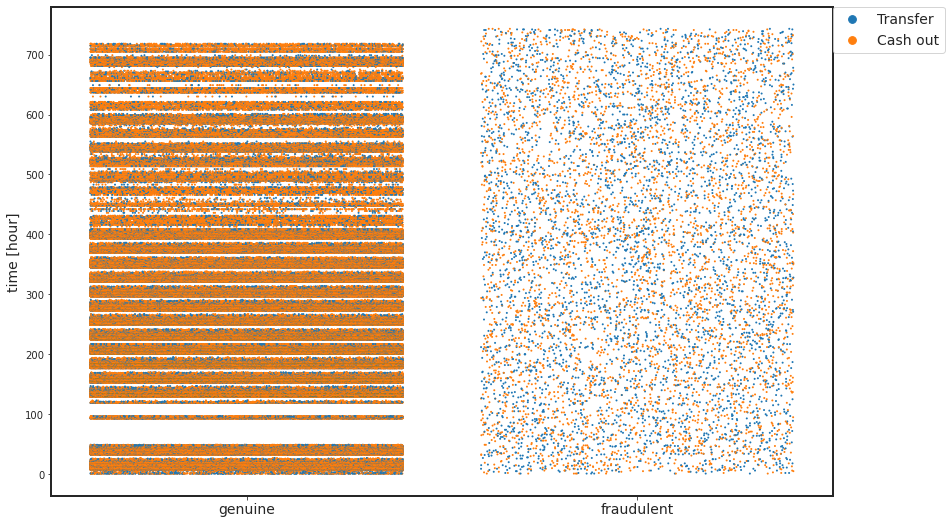

In [13]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 14)

We can see that genuine transactions have a more regular pattern, occuring at intervals with periods in between which do not see any genuine transactions occuring. These periods could represent weekends or holidays resulting in businesses being closed. Meanwhile, the fraudulent transactions are far more evenly distributed, with no discernible pattern. 

Furthermore, it's clear that the majority of genuine transcations are of type CASH OUT, whereas fraudulent transactions feature TRANSFER types far more prominently. 

-----

Next, we compare the transfer amount distributions for genuine and fraudulent transctions. 

Text(0, 0.5, 'amount')

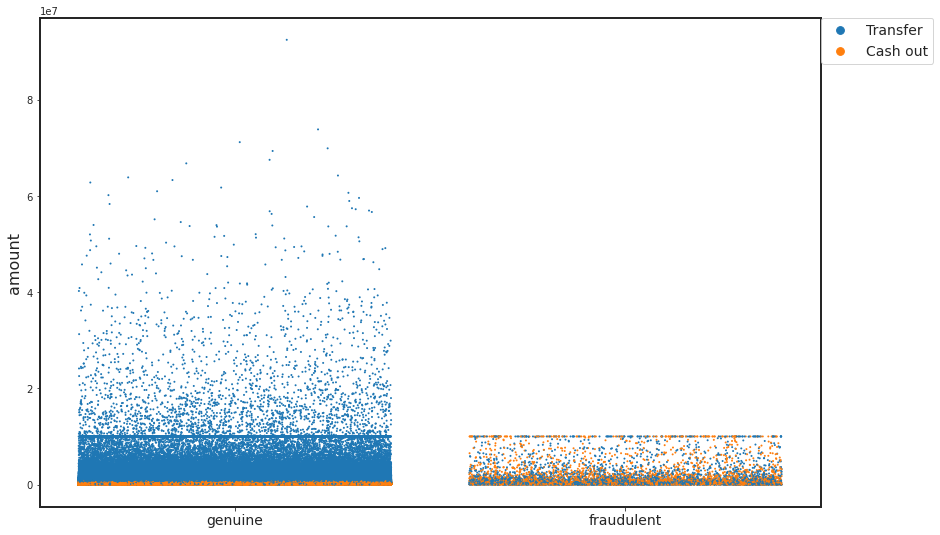

In [14]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)

There is no clear pattern between genuine and fraudulent transactions by simply considering the amount. However, it appears there is a ceiling on the limit of a fraudulent transaction (10,000,000).

-----

Finally, we visualise the feature we created earlier `errorBalanceDest`, which is simply calculated by taking the previous balance of the destination account, plus the amount which was transferred minus new balance in the account. 

Remember, that many of the fraudulent transactions we observed had 0 account balance both before and after a non-zero sum of money was transferred. Therefore, the `errorBalanceDest` of these transactions will be a positive number equivalent to the value of the transfer.

Text(0, 0.5, 'errorBalanceDest')

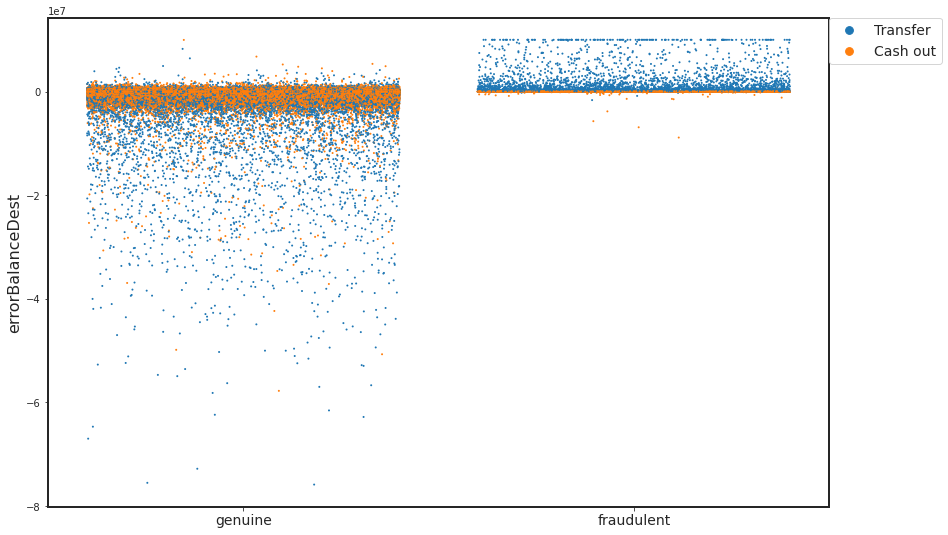

In [22]:
limit = len(X)
ax = plotStrip(Y[:limit], X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('errorBalanceDest', size = 16)

From this figure we can see a clear distinction between genuine and fraudulent transactions with positive errorBalanceDest being recorded overwhelmingly more so for fraudulent transactions than genuine ones. 

# Model Training

Next we will train our predictor, to determine in an automated fashion whether a new transaction is fraudulent or not. 

We will be using an XGBoost classifier as it is naturally suited to handling such an imbalanced dataset, whereby only 0.3% of the transactions are fraudulent. 

In [25]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


We split our data into training and testing sets. 

In [23]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

We also weight the positive class (fraudulent) more than the negative class (genuine) to help account for the overrepresentation of genuine transactions in the dataset. 

In [24]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())

We then train and score an XGBoost classifier. 

In [26]:
# Long computation in this cell (~1.8 minutes)

clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4, use_label_encoder=False)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

[12:45:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.9984747968838775


We achieve a very impressive 0.99 AUPRC! Which means our classifier is accurately distinguishing between transactions. 

We can visualise the features which are most important to our new XGBoost classifier as shown below. 

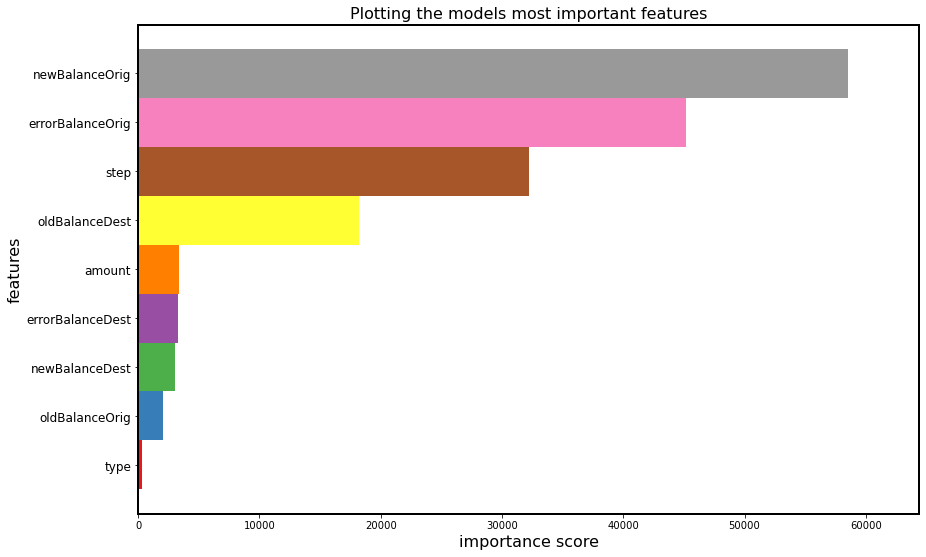

In [28]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Plotting the models most important features', size = 16);

We can also view the top level decisions which the model has selected. We can see that our engineered feature of `errorBalanceOrig` is the first decision point made by the model. 

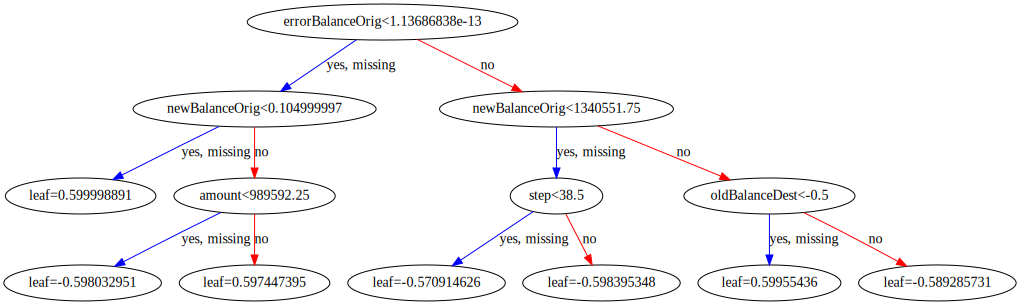

In [30]:
to_graphviz(clf)

We can now save our model, and upload it to an artefact store (in this case a Google storage bucket) ready for deployment.

We will be making use of the pre-packaged XGBoost model server, and therefore Seldon expects our classifier to be saved as `model.bst`. 

In [31]:
clf.save_model('model.bst')

We will now upload our saved model file to a Google storage bucket. 

### !!! IMPORTANT !!!
Make sure you fill in the WORKSHOP-NAME and YOUR-NAME to ensure you're not overwriting existing artefacts.

In [32]:
!gsutil cp model.bst gs://tom-seldon-examples/<WORKSHOP-NAME>/<YOUR-NAME>/model.bst



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://model.bst [Content-Type=application/octet-stream]...
/ [1 files][ 64.2 KiB/ 64.2 KiB]                                                
Operation completed over 1 objects/64.2 KiB.                                     


# Deployment
We can now deploy our model to the dedicated Seldon Deploy cluster which we have configured for this workshop. To do so we will interact with the Seldon Deploy SDK and deploy our model using that. 

First, setting up the configuration and authentication required to access the cluster. Make sure to fill in the `SD_IP` variable to be the same as the cluster you are using. 

In [57]:
SD_IP = "157.245.31.182"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"

def auth():
    auth = OIDCAuthenticator(config)
    config.access_token = auth.authenticate("admin@seldon.io", "12341234")
    api_client = ApiClient(config)
    return api_client

Now we have configured the IP correctly as well as setup our authentication function we can desrcibe the deployment we would like to create. 

You will need to fill in the `DEPLOYMENT_NAME`, `NAMESPACE`, and the `MODEL_LOCATION`, the rest of the deployment description has been templated for you. 

For the `MODEL_LOCATION` you do not need to specify the path all the way up to `model.bst` e.g. if you saved your classifier under `gs://tom-seldon-examples/my-workshop/tom/model.bst` your `MODEL_LOCATION` should be `gs://tom-seldon-examples/my-workshop/tom` and Seldon will automatically pick up the classifier artifact stored there. 

In [58]:
DEPLOYMENT_NAME = "fraud-detector"
NAMESPACE = "dev"
MODEL_LOCATION = "gs://tom-seldon-examples/leit-workshop/tom"

PREPACKAGED_SERVER = "XGBOOST_SERVER"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

We can now invoke the `SeldonDeploymentsApi` and create a new Seldon Deployment. 

In [59]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

OAuthError: unauthorized_client: INVALID_CREDENTIALS: Invalid client credentials

We can now send requests to our model. As an example of a normal request:
```
{
    "data": {
        "names": ["step", "type", "amount", "oldBalanceOrig", "newBalanceOrig",
                  "oldBalanceDest", "newBalanceDest", "errorBalanceOrig", "errorBalanceDest"],
        "ndarray": [
            [205, 1, 63243.44, -1.00, -1.00, 1853683.32, 1916926.76, 63243.44, 0]
        ]
    }
}
```
And a fraudulent transaction too:

```
{
    "data": {
        "names": ["step", "type", "amount", "oldBalanceOrig", "newBalanceOrig",
                  "oldBalanceDest", "newBalanceDest", "errorBalanceOrig", "errorBalanceDest"],
        "ndarray": [
            [629, 1, 2433009.28, 2433009.28, 0.00, 0.00, 2433009.28, 0.00, 0.00]
        ]
    }
}
```

# Conclusion
We have successfully cleaned and explored our dataset. We then trained an XGBoost classifier to distinguish between fraudulent and normal transactions which we subsequently saved and uploaded to a cloud storage bucket. Finally, we deployed our model using the Seldon Deploy SDK, and used it to classify both a normal and a fraudlent transaction.